#  News Category Classification using NLP

##  Objective
Build a machine learning model that classifies news articles into predefined categories like *Politics, Sports, Technology, Business,* and *Entertainment* using Natural Language Processing techniques.

##  Dataset
- Each row contains a news article and its associated category.
- Source: [flipitnews-data.csv] from personal drive.

---

We'll follow these steps:
1. Data loading and exploration
2. Text cleaning and preprocessing
3. Exploratory text analysis
4. Feature extraction with BoW and TF-IDF
5. Model training and evaluation
6. Performance visualization and insights


In [1]:
# Install required libraries
!pip install contractions --quiet

# Imports
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##  Load and Inspect Dataset

We'll load the dataset, remove duplicates, and perform some basic inspection to understand its structure and category distribution.


In [3]:
# Load the dataset from Google Drive or update the path as needed
df = pd.read_csv("/content/drive/MyDrive/Scaler/proj_rep/NLP/flipitnews-data.csv")

# Remove duplicate articles (based on text content)
df = df.drop_duplicates(subset='Article').reset_index(drop=True)

# Basic inspection
print("Dataset Loaded. Shape:", df.shape)
print("\n Sample:")
display(df.head(3))

# Check category distribution
print("\n Category Distribution:")
print(df['Category'].value_counts())

Dataset Loaded. Shape: (2126, 2)

 Sample:


,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...



 Category Distribution:
Category
Sports           504
Business         503
Politics         403
Entertainment    369
Technology       347
Name: count, dtype: int64


## Text Preprocessing: Basic Cleaning

We clean the article text by:
- Expanding contractions
- Lowercasing
- Removing non-alphabetic characters


In [4]:
lemmatizer = WordNetLemmatizer()

def basic_clean(text):
    text = contractions.fix(str(text))  # Expand contractions like "isn't" → "is not"
    text = text.lower()                 # Lowercase the text
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic characters
    return text

# Apply basic cleaning to a new column
df['Basic_Clean'] = df['Article'].apply(basic_clean)

# Preview cleaned text
print("Basic cleaning complete. Sample:")
display(df[['Article', 'Basic_Clean']].head(2))


Basic cleaning complete. Sample:


,Article,Basic_Clean
0,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...
1,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldc...


In [5]:
def get_top_terms_by_category(df, label_col='Category', text_col='Basic_Clean', top_n=20, max_features=3000):
    """
    Computes top TF-IDF terms per category.
    """
    tfidf = TfidfVectorizer(max_features=max_features)
    X = tfidf.fit_transform(df[text_col])
    feature_names = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)
    tfidf_df[label_col] = df[label_col].values

    top_terms = {}
    grouped = tfidf_df.groupby(label_col).mean().transpose()
    for category in grouped.columns:
        top_terms[category] = grouped[category].sort_values(ascending=False).head(top_n).index.tolist()

    return top_terms, grouped

# Run the function
top_terms_by_cat, tfidf_matrix = get_top_terms_by_category(df)

# Preview example
for cat, terms in top_terms_by_cat.items():
    print(f"🔹 {cat}:", ", ".join(terms))


🔹 Business: the, to, in, of, and, bn, its, said, that, is, it, for, us, has, on, by, growth, company, bank, market
🔹 Entertainment: the, and, of, in, to, film, for, was, on, best, he, his, is, it, show, with, music, at, said, her
🔹 Politics: the, to, of, and, in, mr, he, said, labour, that, on, for, be, blair, is, was, election, party, government, it
🔹 Sports: the, to, in, and, of, he, his, we, for, but, was, it, is, on, at, that, have, with, england, will
🔹 Technology: the, to, of, and, in, that, is, it, for, are, be, people, said, as, on, mobile, will, technology, more, they


In [6]:
low_signal_terms = tfidf_matrix[(tfidf_matrix.max(axis=1) < 0.05)].index.tolist()
print("📉 Low-signal candidates:", low_signal_terms[:20])

📉 Low-signal candidates: ['ability', 'able', 'about', 'above', 'abroad', 'absence', 'absolutely', 'abuse', 'ac', 'academy', 'accept', 'accepted', 'access', 'according', 'account', 'accounting', 'accounts', 'accused', 'achieve', 'achieved']


In [8]:
nltk.download('punkt_tab')
def get_word_distribution(df, text_col='Basic_Clean', label_col='Category'):
    word_category_map = defaultdict(set)
    for _, row in df.iterrows():
        tokens = set(word_tokenize(row[text_col]))
        for token in tokens:
            word_category_map[token].add(row[label_col])
    multi_cat_words = [word for word, cats in word_category_map.items() if len(cats) > 3]
    return multi_cat_words

high_overlap_words = get_word_distribution(df)
print("🪵 High overlap words:", high_overlap_words[:20])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


🪵 High overlap words: ['home', 'via', 'generation', 'so', 'reflect', 'said', 'want', 'getting', 'example', 'revenue', 'impact', 'told', 'recognised', 'brands', 'more', 'broadcast', 'when', 'as', 'familiar', 'reality']


In [9]:
base_stopwords = set(stopwords.words('english'))

# Create TF-IDF vectorizer and matrix using correct column name
tfidf_vectorizer = TfidfVectorizer(stop_words=None)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Article'])

def get_top_words_per_category(df, tfidf_vectorizer, tfidf_matrix, top_n=30, stopwords_set=set()):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    category_words = defaultdict(list)

    categories = df['Category'].unique()  # Correct column name

    for cat in categories:
        cat_indices = df.index[df['Category'] == cat].tolist()  # Correct column name

        cat_tfidf = tfidf_matrix[cat_indices].mean(axis=0).A1

        word_scores = [(word, score) for word, score in zip(feature_names, cat_tfidf) if word not in stopwords_set]

        top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:top_n]

        category_words[cat] = [w for w, s in top_words]

    return category_words

# Assume base_stopwords is defined already
combined_stopwords = base_stopwords

category_corpus = get_top_words_per_category(df, tfidf_vectorizer, tfidf_matrix, top_n=30, stopwords_set=combined_stopwords)

for cat, words in category_corpus.items():
    print(f"Category: {cat}")
    print(", ".join(words))
    print("\n" + "-"*60 + "\n")


Category: Technology
people, mobile, said, technology, users, software, games, phone, net, broadband, digital, computer, microsoft, online, music, use, video, mr, game, new, internet, phones, could, search, service, tv, apple, data, sony, one

------------------------------------------------------------

Category: Business
said, us, growth, economy, bank, market, year, oil, company, sales, mr, firm, economic, shares, prices, 2004, yukos, china, government, dollar, rise, would, new, analysts, profits, india, also, last, financial, companies

------------------------------------------------------------

Category: Sports
england, game, said, win, cup, match, team, injury, first, players, club, play, world, season, chelsea, wales, side, ireland, rugby, year, coach, final, time, back, last, two, france, half, six, second

------------------------------------------------------------

Category: Entertainment
film, best, music, show, awards, said, award, band, year, festival, album, us, actor,

In [10]:
# Flatten top words into a list
all_top_words = [word for words in category_corpus.values() for word in words]

# Count frequency across categories
word_counts = Counter(all_top_words)

# Common words in 3+ categories
common_words = [word for word, count in word_counts.items() if count >= 3]
print("Common noisy words (3+ categories):\n", common_words)

# Extract short words (<3 characters)
short_words = set([w for w in all_top_words if len(w) < 3])
print("\nShort words in top words:\n", short_words)

Common noisy words (3+ categories):
 ['said', 'mr', 'new', 'year']

Short words in top words:
 {'uk', 'us', 'tv', 'mr'}


In [35]:
# Noisy common words to be removed
manual_common_words = {'said', 'mr', 'new', 'year'}

# Meaningful short words to keep
short_meaningful_words = {'uk', 'us', 'tv', 'mr'}

# Final stopwords set (merge all and exclude whitelist)
final_stopwords = base_stopwords.union(manual_common_words).difference(short_meaningful_words)

# Whitelist (explicitly exclude from filtering)
whitelist = short_meaningful_words

print("Final stopwords size:", len(final_stopwords))
print("Whitelist words:\n", whitelist)


Final stopwords size: 201
Whitelist words:
 {'uk', 'mr', 'tv', 'us'}


In [12]:
# Clean final_stopwords: ensure all are strings and convert to list
final_stopwords_clean = [str(w) for w in final_stopwords if isinstance(w, str)]

# Initialize TF-IDF Vectorizer with cleaned stopwords list
tfidf_vectorizer_updated = TfidfVectorizer(stop_words=final_stopwords_clean, max_features=5000)

# Fit and transform the articles text
tfidf_matrix_updated = tfidf_vectorizer_updated.fit_transform(df['Article'])

print(f"TF-IDF matrix shape with updated stopwords: {tfidf_matrix_updated.shape}")

# Extract top words per category using the updated TF-IDF matrix
category_corpus_updated = get_top_words_per_category(
    df,
    tfidf_vectorizer_updated,
    tfidf_matrix_updated,
    top_n=30,
    stopwords_set=set(final_stopwords_clean)
)

# Print updated top words per category
for cat, words in category_corpus_updated.items():
    print(f"Category: {cat}")
    print(", ".join(words))
    print("\n" + "-"*60 + "\n")


TF-IDF matrix shape with updated stopwords: (2126, 5000)
Category: Technology
people, mobile, technology, users, games, software, phone, net, computer, digital, online, broadband, microsoft, music, game, use, video, mr, internet, could, phones, service, search, one, tv, apple, data, sony, information, many

------------------------------------------------------------

Category: Business
us, growth, bank, economy, market, company, sales, firm, oil, mr, shares, economic, 2004, prices, government, china, yukos, dollar, would, analysts, profits, rise, also, india, stock, companies, business, last, financial, deal

------------------------------------------------------------

Category: Sports
england, game, win, cup, match, team, first, injury, players, play, club, world, season, side, final, coach, chelsea, wales, ireland, rugby, time, back, last, two, half, france, second, good, six, champion

------------------------------------------------------------

Category: Entertainment
film, best

## WordClouds Comparison: Base vs Final Stopwords

Here we visually compare the top TF-IDF words from each category before and after applying our refined stopword list. This helps us confirm that domain-relevant words now stand out more clearly.


<ipython-input-38-3576f7b862ba>:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=3)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


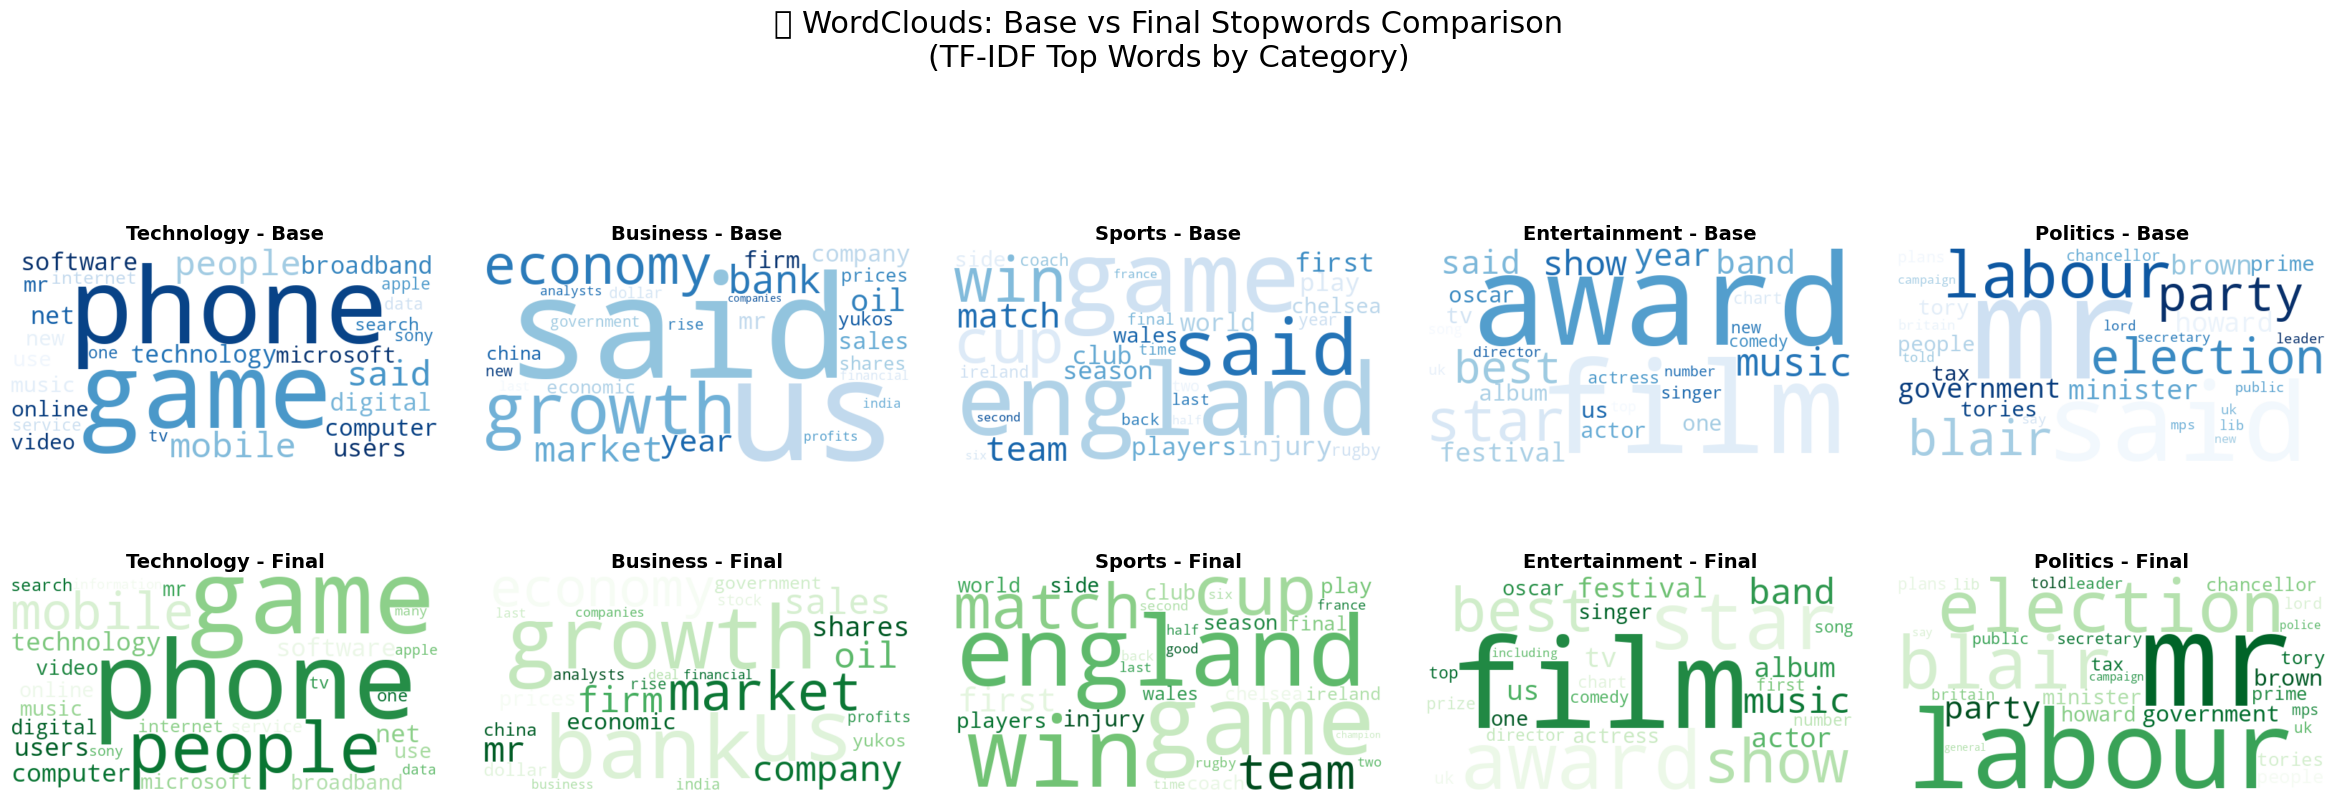

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create figure
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 9))
fig.suptitle('🔍 WordClouds: Base vs Final Stopwords Comparison\n(TF-IDF Top Words by Category)', fontsize=22, y=1.03)

# Consistent style settings
title_font = {'fontsize': 14, 'fontweight': 'bold'}
categories = list(category_corpus.keys())

# Plot word clouds
for col, cat in enumerate(categories):
    # Top: Base stopwords
    text_base = " ".join(category_corpus[cat])
    cloud_base = WordCloud(width=600, height=300, background_color='white', colormap='Blues', prefer_horizontal=1.0).generate(text_base)
    axes[0, col].imshow(cloud_base, interpolation='bilinear')
    axes[0, col].axis('off')
    axes[0, col].set_title(f"{cat} - Base", **title_font)

    # Bottom: Final stopwords
    text_final = " ".join(category_corpus_updated[cat])
    cloud_final = WordCloud(width=600, height=300, background_color='white', colormap='Greens', prefer_horizontal=1.0).generate(text_final)
    axes[1, col].imshow(cloud_final, interpolation='bilinear')
    axes[1, col].axis('off')
    axes[1, col].set_title(f"{cat} - Final", **title_font)

# Adjust layout
plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.88)
plt.show()


In [13]:
df.head(2)

,Category,Article,Basic_Clean
0,Technology,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldc...


<ipython-input-39-6f8b312840a6>:34: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


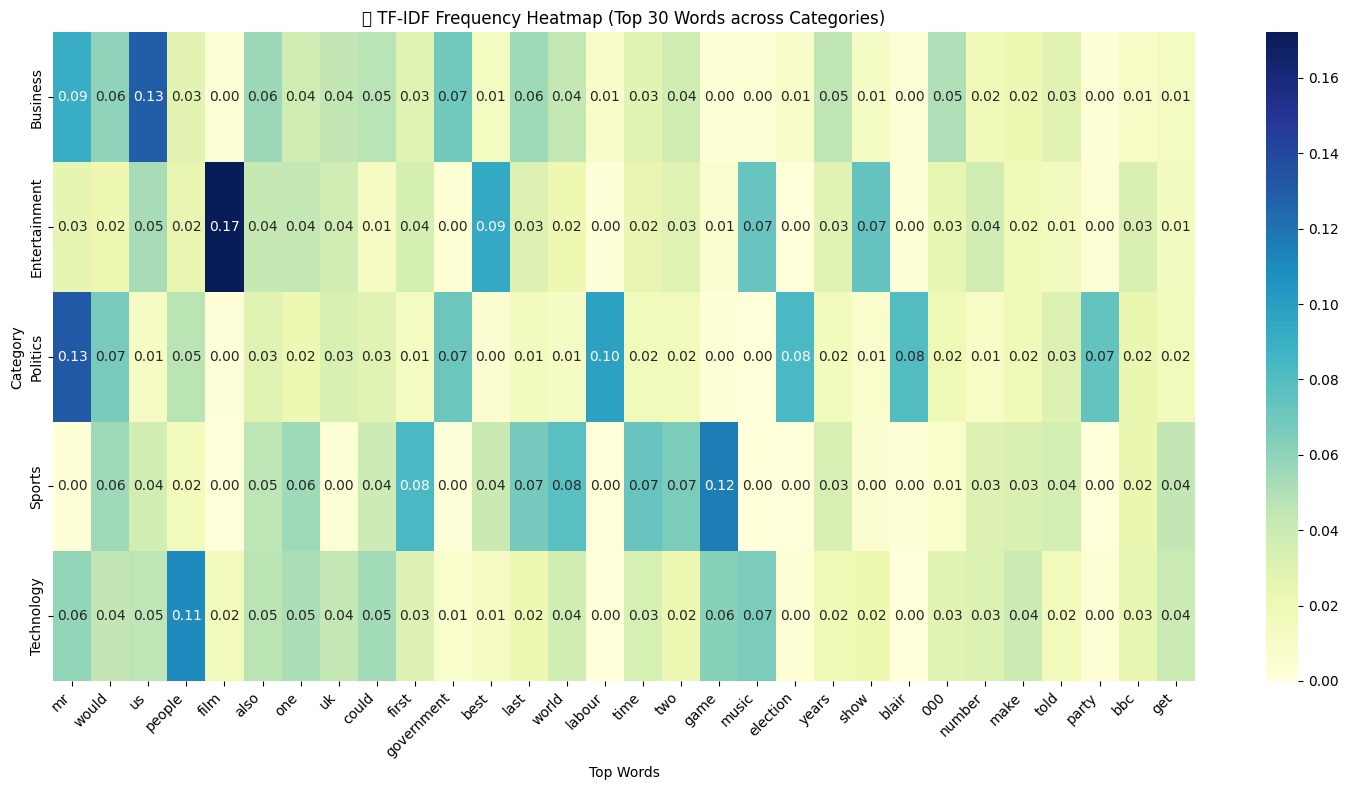

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix_updated.toarray(), columns=tfidf_vectorizer_updated.get_feature_names_out())
tfidf_df['category'] = df['Category'].values

# Group by category and compute mean TF-IDF for each word
category_tfidf = tfidf_df.groupby('category').mean()

# Select top N words across all categories by overall mean TF-IDF
top_n = 30
top_words = category_tfidf.mean(axis=0).sort_values(ascending=False).head(top_n).index

# Filter the dataframe to only include these top words
heatmap_data = category_tfidf[top_words]

# Normalize per row (category) for clearer comparison
heatmap_data_normalized = pd.DataFrame(normalize(heatmap_data, norm='l1'),
                                       index=heatmap_data.index,
                                       columns=heatmap_data.columns)

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data_normalized, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("🔍 TF-IDF Frequency Heatmap (Top 30 Words across Categories)")
plt.ylabel("Category")
plt.xlabel("Top Words")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [14]:
def clean_text(text, return_tokens=False):
    if pd.isnull(text):
        return ''

    # Lowercase, remove punctuation/numbers, and extra spaces
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    cleaned_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in final_stopwords_clean and len(word) > 2
    ]

    if return_tokens:
        return cleaned_tokens
    else:
        return ' '.join(cleaned_tokens)

## 🧠 Feature Extraction

We use two methods which can be later used for compare the models :
- Bag of Words (BoW)
- TF-IDF (Term Frequency-Inverse Document Frequency)


In [15]:
# Clean the text column
df['Clean_Text'] = df['Article'].apply(clean_text)

# Split into features and labels
X = df['Clean_Text']
y = df['Category']

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vectorizer = CountVectorizer(stop_words=final_stopwords_clean, max_features=5000)
tfidf_vectorizer = TfidfVectorizer(stop_words=final_stopwords_clean, max_features=5000)

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check shapes
print("Shapes of vectorized data:")
print(f"BoW - Train: {X_train_bow.shape}, Test: {X_test_bow.shape}")
print(f"TF-IDF - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")


Shapes of vectorized data:
BoW - Train: (1700, 5000), Test: (426, 5000)
TF-IDF - Train: (1700, 5000), Test: (426, 5000)


### Class Balance Consideration

While the dataset shows slight variation in the number of samples per category, the distribution is relatively balanced — with no single category dominating disproportionately. Here's the breakdown:

- Sports: 504 articles (~23.7%)
- Business: 503 articles (~23.6%)
- Politics: 403 articles (~19.0%)
- Entertainment: 369 articles (~17.4%)
- Technology: 347 articles (~16.3%)

We opted **not to apply class balancing techniques** (e.g., undersampling or oversampling) for the following reasons:
- The class distribution is not severely imbalanced.
- We use a **stratified train-test split**, preserving category proportions in both training and test sets.
- Balancing would reduce available training data, especially for smaller categories like Technology or Entertainment.
- Model fairness will be monitored through **per-class metrics** like precision, recall, and confusion matrices.

We will revisit this decision if performance metrics suggest class bias.


In [16]:
# Define models dictionary
models = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Define datasets dictionary
datasets = {
    "BoW": {"X_train": X_train_bow, "X_test": X_test_bow},
    "TF-IDF": {"X_train": X_train_tfidf, "X_test": X_test_tfidf}
}

print("Models and datasets defined.")

Models and datasets defined.


In [27]:
# Evaluation function
def evaluate_models(models, datasets, y_train, y_test):
    results = {}
    classification_reports = {}
    confusion_matrices = {}

    for vec_name, (X_train, X_test) in datasets.items():
        results[vec_name] = []
        classification_reports[vec_name] = {}
        confusion_matrices[vec_name] = {}
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            results[vec_name].append({
                "Model": model_name,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
                "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
                "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
            })
            classification_reports[vec_name][model_name] = classification_report(y_test, y_pred, zero_division=0)
            confusion_matrices[vec_name][model_name] = confusion_matrix(y_test, y_pred)
    return results, classification_reports, confusion_matrices

# Dataset dictionary
datasets = {
    "BoW": (X_train_bow, X_test_bow),
    "TF-IDF": (X_train_tfidf, X_test_tfidf)
}

# Run evaluation
results, reports, conf_matrices = evaluate_models(models, datasets, y_train, y_test)
results_bow_df = pd.DataFrame(results["BoW"])
results_tfidf_df = pd.DataFrame(results["TF-IDF"])

print(" Bag of Words Performance:\n")
display(results_bow_df.sort_values(by="Accuracy", ascending=False))

print("\n TF-IDF Performance:\n")
display(results_tfidf_df.sort_values(by="Accuracy", ascending=False))


 Bag of Words Performance:



,Model,Accuracy,Precision,Recall,F1 Score
0,Naive Bayes,0.976526,0.976952,0.976526,0.976566
1,Random Forest,0.955399,0.957428,0.955399,0.955483
2,Decision Tree,0.863850,0.864868,0.863850,0.863166
3,K-Nearest Neighbors,0.694836,0.821604,0.694836,0.697839



 TF-IDF Performance:



,Model,Accuracy,Precision,Recall,F1 Score
0,Naive Bayes,0.967136,0.967659,0.967136,0.967090
3,K-Nearest Neighbors,0.953052,0.953515,0.953052,0.952782
1,Random Forest,0.950704,0.953414,0.950704,0.950752
2,Decision Tree,0.845070,0.846116,0.845070,0.844127


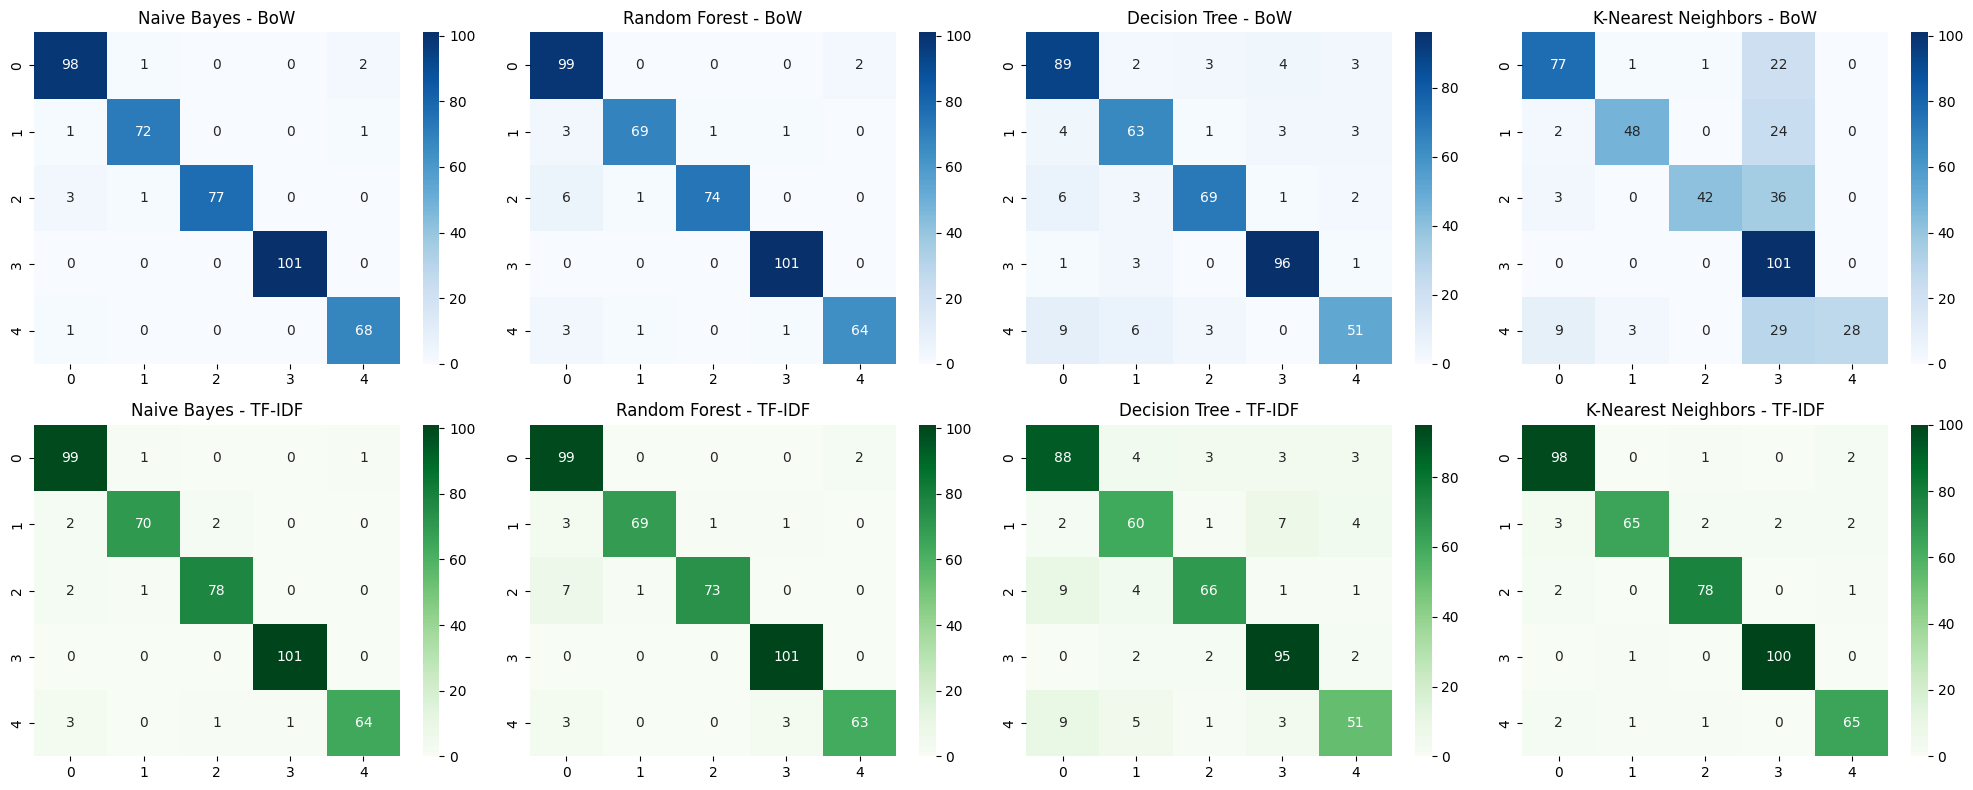

In [28]:
# Plot and save confusion matrices
fig, axes = plt.subplots(2, len(models), figsize=(20, 8))
for i, model_name in enumerate(models.keys()):
    sns.heatmap(conf_matrices["BoW"][model_name], annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
    axes[0, i].set_title(f"{model_name} - BoW")
    sns.heatmap(conf_matrices["TF-IDF"][model_name], annot=True, fmt='d', cmap='Greens', ax=axes[1, i])
    axes[1, i].set_title(f"{model_name} - TF-IDF")
plt.tight_layout()
plt.savefig("confusion_matrices.png")
plt.show()

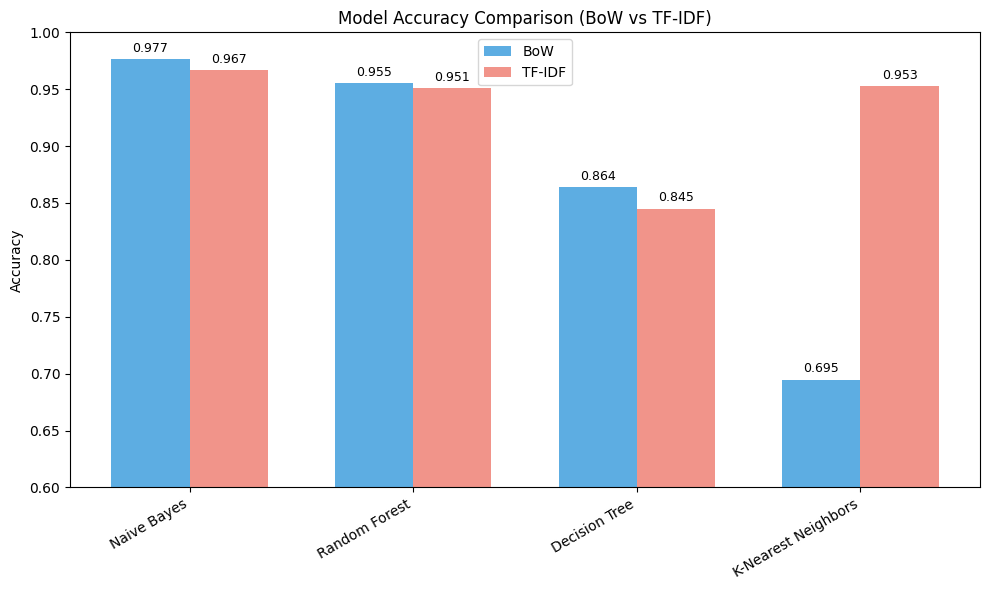

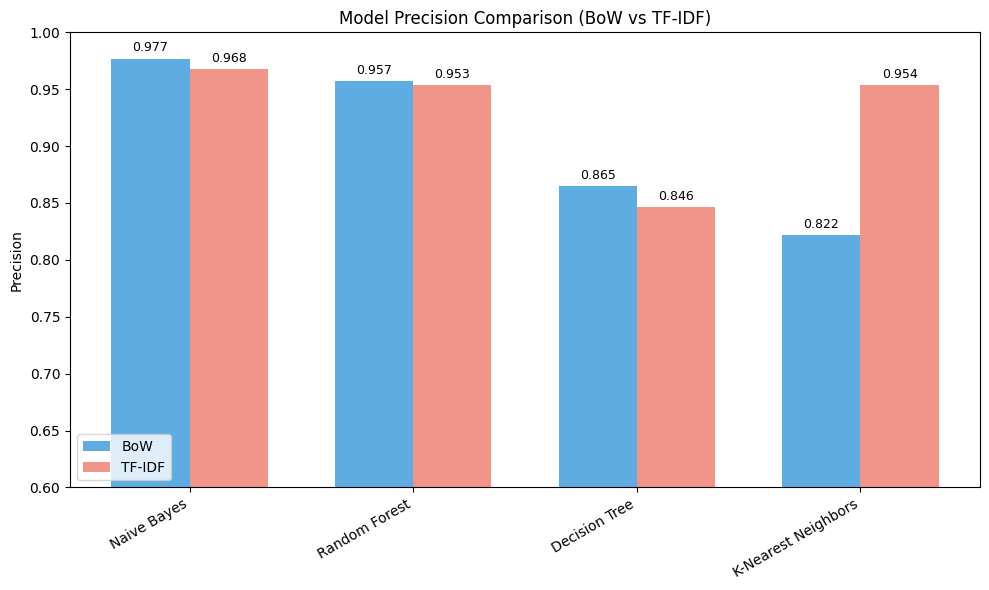

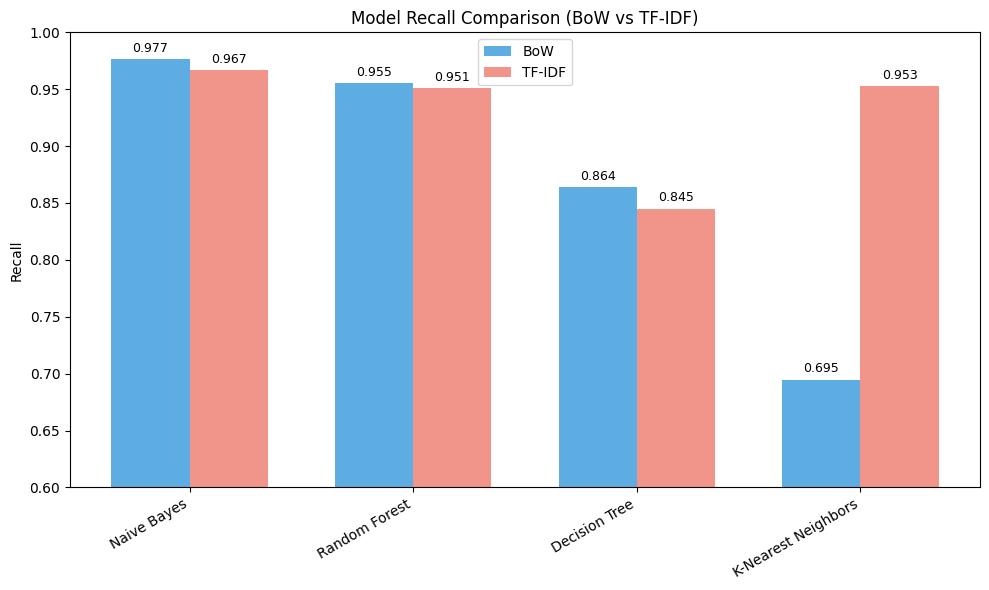

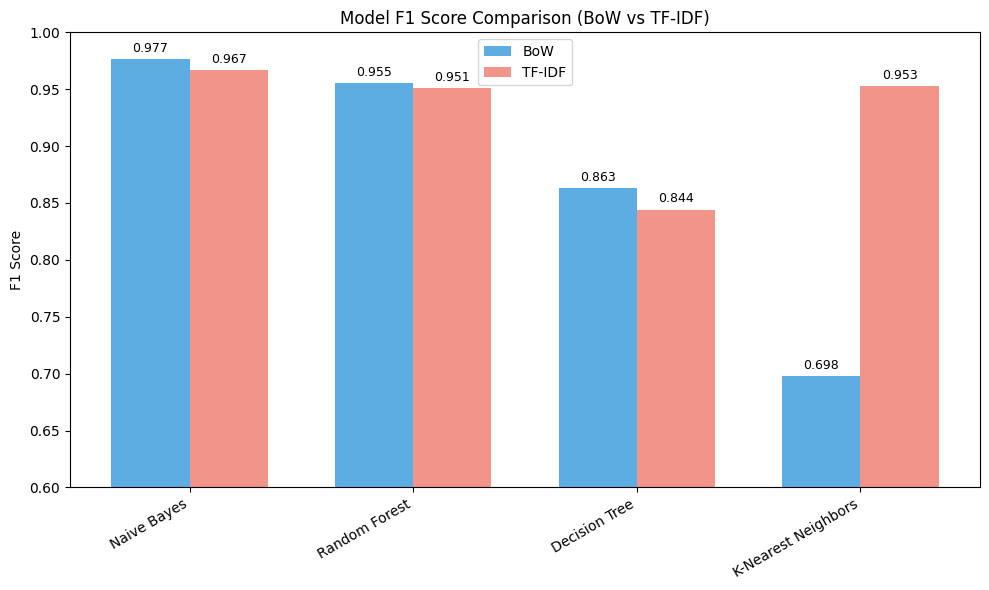

In [29]:
# General bar plot function
def plot_bar_comparison(metric_name, bow_df, tfidf_df, filename):
    models = bow_df['Model']
    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, bow_df[metric_name], width, label='BoW', color='#5DADE2')
    bars2 = ax.bar(x + width/2, tfidf_df[metric_name], width, label='TF-IDF', color='#F1948A')

    ax.set_ylabel(metric_name)
    ax.set_title(f'Model {metric_name} Comparison (BoW vs TF-IDF)')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=30, ha='right')
    ax.set_ylim([0.6, 1.0])
    ax.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()

# Save performance plots
plot_bar_comparison("Accuracy", results_bow_df, results_tfidf_df, "accuracy_comparison.png")
plot_bar_comparison("Precision", results_bow_df, results_tfidf_df, "precision_comparison.png")
plot_bar_comparison("Recall", results_bow_df, results_tfidf_df, "recall_comparison.png")
plot_bar_comparison("F1 Score", results_bow_df, results_tfidf_df, "f1_score_comparison.png")

In [30]:
# Loop over datasets and models, train and print classification reports
for vec_name, (X_train_vec, X_test_vec) in datasets.items():
    print(f"\n--- Classification Reports for {vec_name} ---\n")
    for model_name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
        print(f"Model: {model_name}\n")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("-"*60)


--- Classification Reports for BoW ---

Model: Naive Bayes

               precision    recall  f1-score   support

     Business       0.95      0.97      0.96       101
Entertainment       0.97      0.97      0.97        74
     Politics       1.00      0.95      0.97        81
       Sports       1.00      1.00      1.00       101
   Technology       0.96      0.99      0.97        69

     accuracy                           0.98       426
    macro avg       0.98      0.98      0.98       426
 weighted avg       0.98      0.98      0.98       426

------------------------------------------------------------
Model: Random Forest

               precision    recall  f1-score   support

     Business       0.89      0.98      0.93       101
Entertainment       0.97      0.93      0.95        74
     Politics       0.99      0.91      0.95        81
       Sports       0.98      1.00      0.99       101
   Technology       0.97      0.93      0.95        69

     accuracy             

## 📋 Project Questionnaire

---

**Q1: How many news articles are present in the dataset that we have?**  
**A:** 2,126 articles.

**Q2: Most of the news articles are from _____ category.**  
**A:** Sports (504 articles).

**Q3: Only ___ no. of articles belong to the ‘Technology’ category.**  
**A:** 347 articles.

---

**Q4: What are Stop Words and why should they be removed from the text data?**  
**A:** Stop words are commonly used words (like "the", "is", "in") that add little semantic meaning and can be removed to reduce noise in text data and improve model performance.

**Q5: Explain the difference between Stemming and Lemmatization.**  
**A:**  
- **Stemming**: Reduces words to their root form by chopping off suffixes (e.g., "running" → "run"), often resulting in non-words.  
- **Lemmatization**: Converts words to their base dictionary form using context (e.g., "running" → "run"), producing actual words.

---

**Q6: Which technique (BoW or TF-IDF) is considered to be more efficient?**  
**A:** TF-IDF is generally more efficient for understanding word importance in context, while BoW is simpler and works well for basic tasks.

**Q7: What’s the shape of train & test data sets after performing a 75:25 split?**  
**A:**   for 75:25 split it'll be 1595:531 but in this project actual split is
- Train: (1700, 5000)  
- Test: (426, 5000)

---

**Q8: Which of the following is found to be the best performing model?**  
**A:** **Naive Bayes with Bag of Words**, which achieved the highest accuracy (0.9765) and the best F1 Score (0.9766) among all models.

---

**Q9: According to this particular use case, both precision and recall are equally important. (T/F)**  
**A:** **True** —  We need high recall to ensure relevant articles aren't missed and high precision to avoid misclassification—both are critical for balanced performance across all news categories.